# Library

In [1]:
from skimage.feature import greycomatrix, greycoprops
from skimage.color import rgb2gray
from skimage.io import imread_collection
from skimage import img_as_ubyte

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,accuracy_score
from scipy.stats import randint as sp_randint

from IPython.display import clear_output
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import time

# Data

In [2]:
Glaucoma = imread_collection("../../../Documents/Bases/RIMONE_v2/Training/Glaucoma/*.jpg")
Normal = imread_collection("../../../Documents/Bases/RIMONE_v2/Training/Normal/*.jpg")

# Gray Level Co-occurrence Matrix

In [3]:
def GLCM(img):
    img = rgb2gray(img)
    img = img_as_ubyte(img)
    
    bins = np.array([0, 32, 64, 96, 128, 160, 192, 224, 255]) # 8 bits
    inds = np.digitize(img, bins)
    
    max_value = inds.max()+1
 
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)
    
    props = np.zeros((24))
    
    contraste = greycoprops(matrix_coocurrence, 'contrast')
    diss = greycoprops(matrix_coocurrence, 'dissimilarity')
    homog = greycoprops(matrix_coocurrence, 'homogeneity')
    energ = greycoprops(matrix_coocurrence, 'energy')
    correl = greycoprops(matrix_coocurrence, 'correlation')
    asm = greycoprops(matrix_coocurrence, 'ASM')
    
    props[0] = contraste[0][0]  #1
    props[1] = contraste[0][1]  #2
    props[2] = contraste[0][2]  #3
    props[3] = contraste[0][3]  #4
    props[4] = diss[0][0]       #5
    props[5] = diss[0][1]       #6
    props[6] = diss[0][2]       #7
    props[7] = diss[0][3]       #8
    props[8] = homog[0][0]      #9
    props[9] = homog[0][1]      #10
    props[10] = homog[0][2]     #11
    props[11] = homog[0][3]     #12
    props[12] = energ[0][0]     #13
    props[13] = energ[0][1]     #14
    props[14] = energ[0][2]     #15
    props[15] = energ[0][3]     #16
    props[16] = correl[0][0]    #17
    props[17] = correl[0][1]    #18
    props[18] = correl[0][2]    #19
    props[19] = correl[0][3]    #20
    props[20] = asm[0][0]       #21
    props[21] = asm[0][1]       #22
    props[22] = asm[0][2]       #23
    props[23] = asm[0][3]       #24

    return props


In [4]:
labels = np.concatenate((np.ones(len(Glaucoma)),np.zeros(len(Normal))))
features = np.zeros((len(labels),24))

for id_img,img in enumerate(Glaucoma):
    features[id_img] = GLCM(img)
for id_img,img in enumerate(Normal):
    features[len(Glaucoma)+id_img] = GLCM(img)

C:\Users\patri\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [5]:
train = 0.9
test = 1-train

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test)

# Random Forest Parameter

In [7]:
def rf_parameter_estimation(xEst, yEst):
    
    clf = RandomForestClassifier(n_estimators=20)    
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10,1000,50),
                  "max_depth": range(1,100),
                  "max_features": sp_randint(1, xEst.shape[1]),
                  "min_samples_split": sp_randint(2, xEst.shape[1]),
                  "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
    
    
    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search,scoring=make_scorer(accuracy_score))
    
    
    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

# Principal Component Analysis

In [8]:
def pca(X_train, X_test,y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train,y_train)
    transform = pca.transform(X_test)
    return transform

In [9]:
components = [4,8,12,16]

In [10]:
results_rf = np.zeros(len(components)+1)

start = time.time()
for id_comp,comp in enumerate(components):
    
    print('-------------','n comp. = ',comp,'-------------')
    
    X_train_pca = pca(X_train,X_train,y_train,comp)
    
    X_test_pca = pca(X_train,X_test,y_train,comp)
    
    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca,y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc

parameters = rf_parameter_estimation(X_train_pca, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train_pca,y_train)
pred = c_rf.predict(X_test_pca)
acc = accuracy_score(y_test, pred)
results_rf[len(components)] = acc
    
end = time.time()
print(end - start)

------------- n comp. =  4 -------------


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.688 (std: 0.055)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 11, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 960}
Model with rank: 2
Mean validation score: 0.685 (std: 0.060)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 360}
Model with rank: 3
Mean validation score: 0.675 (std: 0.071)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 49, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 460}
Model with rank: 3
Mean validation score: 0.675 (std: 0.060)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 110}
------------- n comp. =  8 -------------


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.736 (std: 0.058)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 45, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 710}
Model with rank: 1
Mean validation score: 0.736 (std: 0.048)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 410}
Model with rank: 1
Mean validation score: 0.736 (std: 0.053)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 27, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 710}
Model with rank: 1
Mean validation score: 0.736 (std: 0.040)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 61, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 310}
------------- n comp. =  12 -------------


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.746 (std: 0.042)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 31, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 360}
Model with rank: 1
Mean validation score: 0.746 (std: 0.038)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 910}
Model with rank: 1
Mean validation score: 0.746 (std: 0.052)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 71, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 160}
Model with rank: 1
Mean validation score: 0.746 (std: 0.037)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 79, 'max_features': 7, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 960}
Model with rank: 1
Mean validation score: 0.746 (std: 0.038)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'ma

C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.743 (std: 0.034)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 48, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 310}
Model with rank: 1
Mean validation score: 0.743 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 63, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 610}
Model with rank: 1
Mean validation score: 0.743 (std: 0.029)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 82, 'max_features': 11, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 110}


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.749 (std: 0.045)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 42, 'max_features': 6, 'min_samples_leaf': 11, 'min_samples_split': 8, 'n_estimators': 710}
Model with rank: 2
Mean validation score: 0.746 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 93, 'max_features': 5, 'min_samples_leaf': 11, 'min_samples_split': 3, 'n_estimators': 660}
Model with rank: 2
Mean validation score: 0.746 (std: 0.017)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 10, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 410}
Model with rank: 2
Mean validation score: 0.746 (std: 0.031)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 68, 'max_features': 13, 'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 810}
Model with rank: 2
Mean validation score: 0.746 (std: 0.037)
Parameters: {'bootstrap': True, 'criterion': 'entropy'

# Results

Text(0.5, 1.0, 'Helmets')

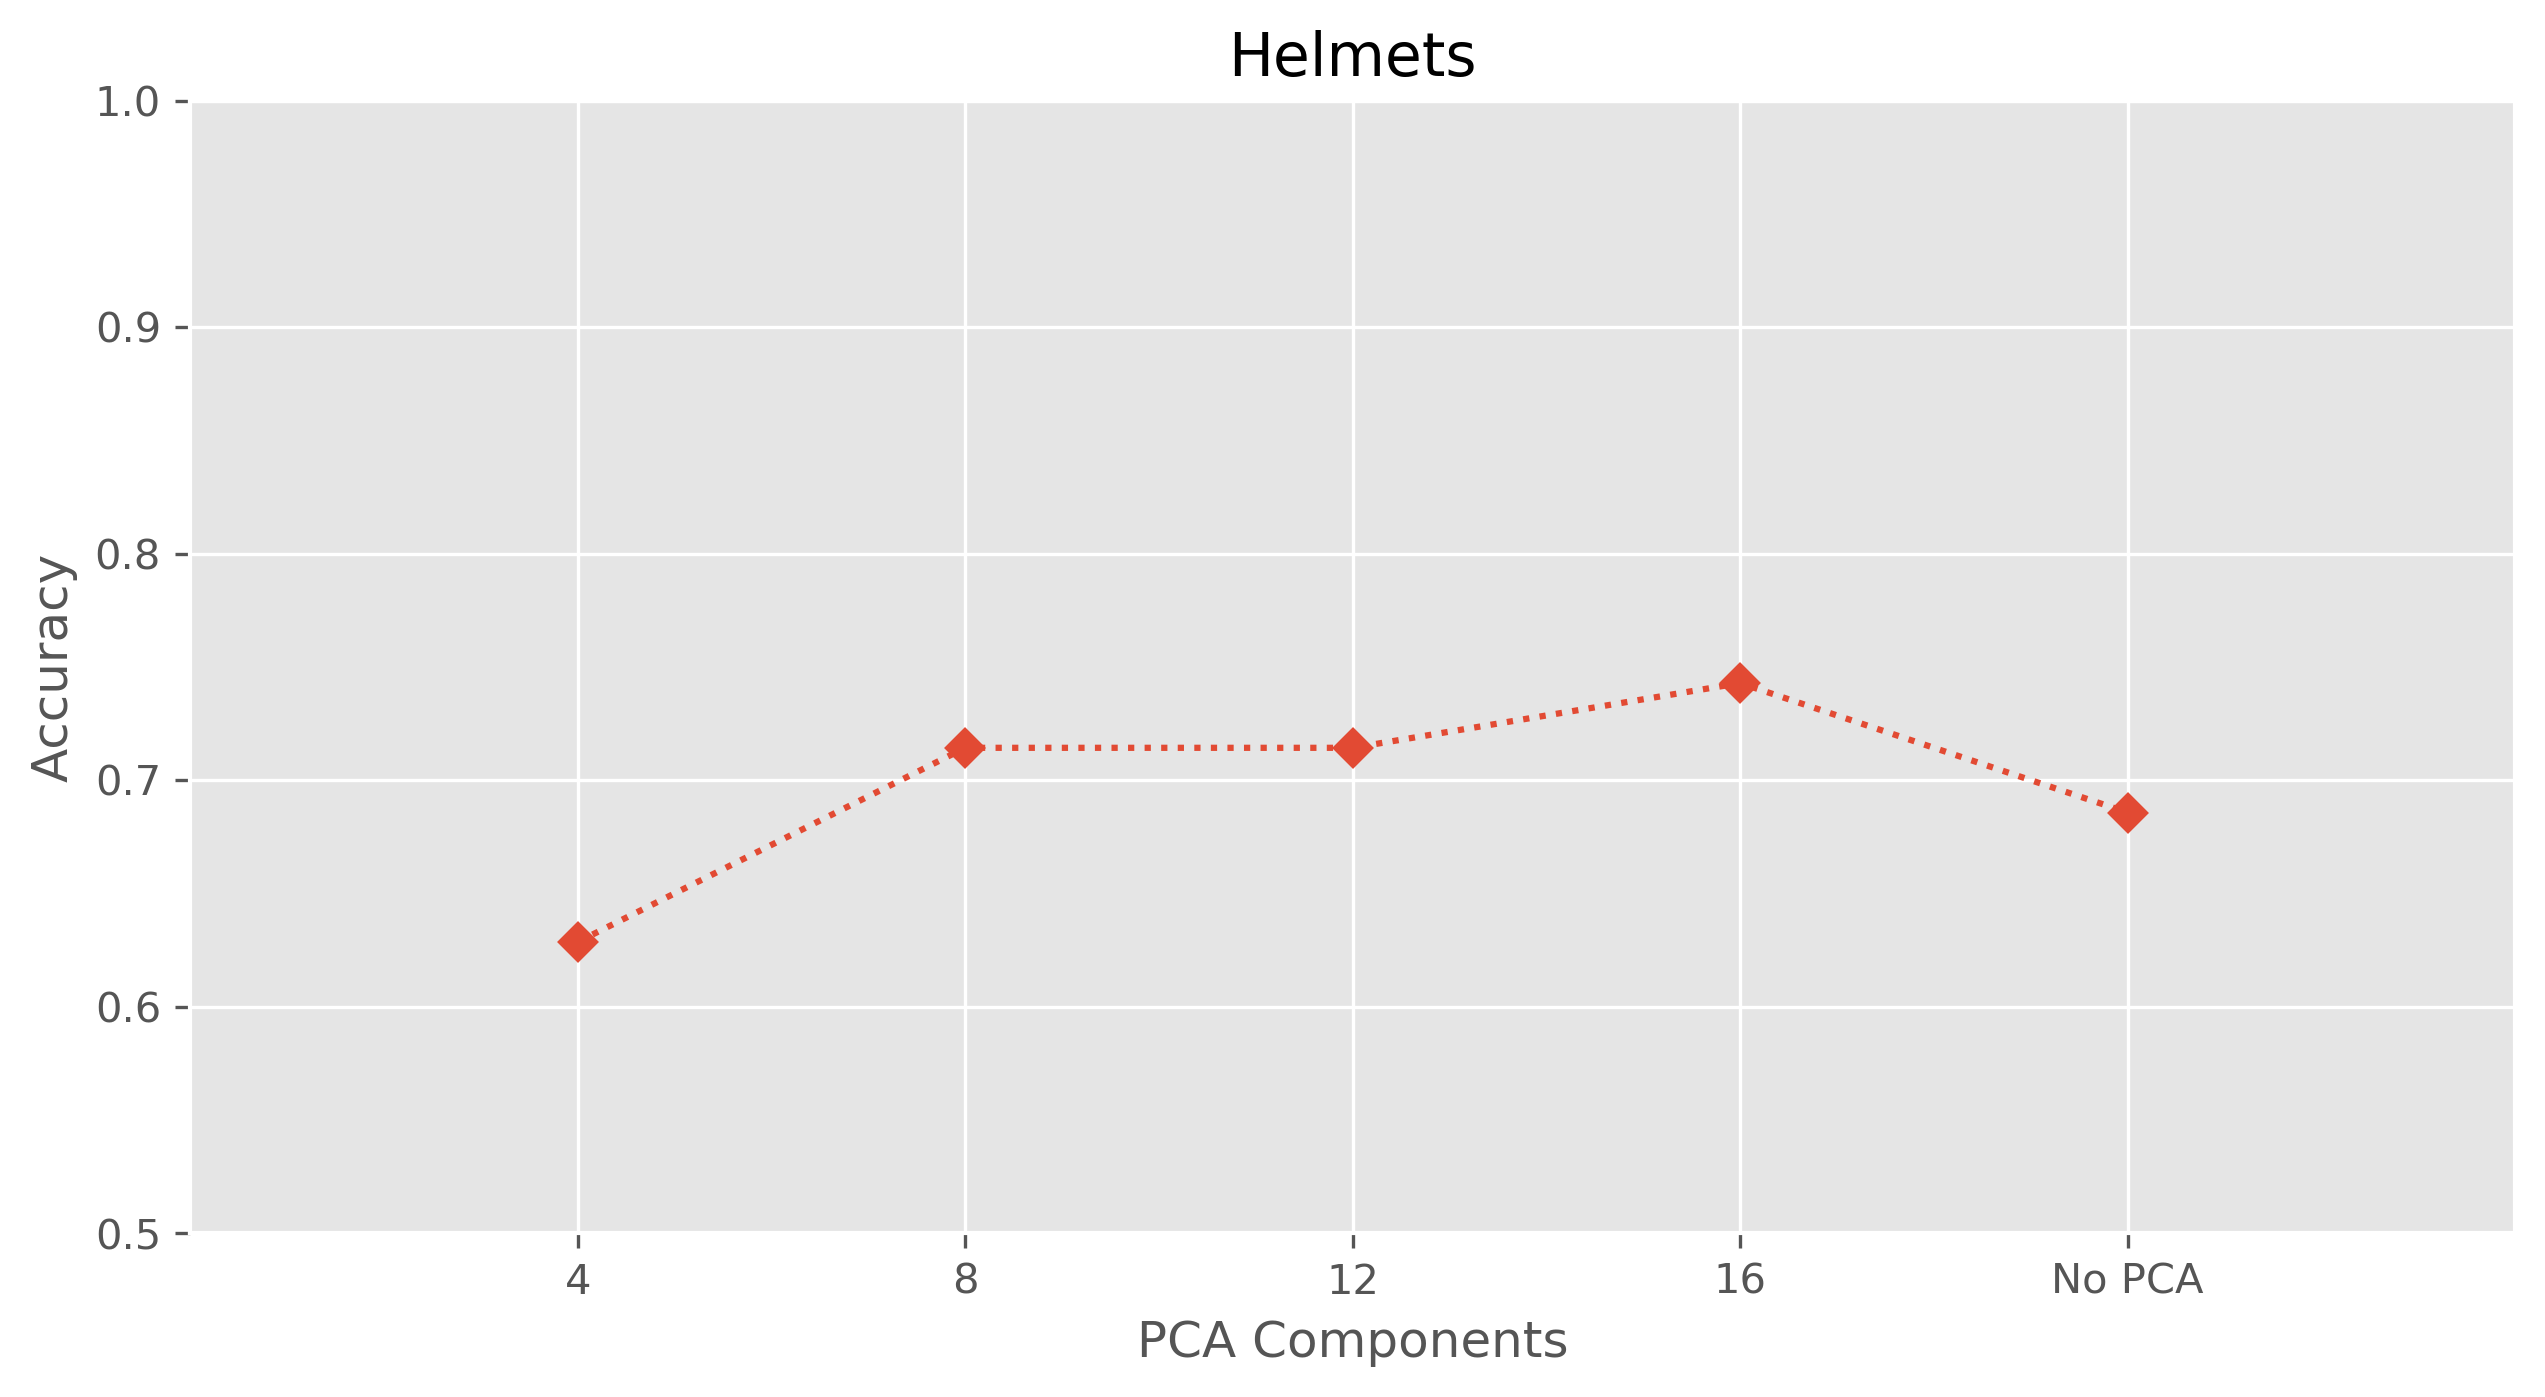

In [11]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (10,5),dpi=300)
ax = plt.subplot(111)
ax.plot(range(1,6),results_rf,marker = 'D',linestyle = ':',label = 'Random Forest')
ax.set_xlim([0,6])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1,6))
ax.set_xticklabels(['4','8','12','16','No PCA'])
ax.set_ylim([0.5,1])
ax.set_title('Helmets')

In [12]:
print("Best Acc: {} \nMethos: {} ".format(results_rf.max(),components[results_rf.argmax()]))

Best Acc: 0.7428571428571429 
Methos: 16 
